In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm

from envs import Maze
from utils import plot_policy,plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

In [2]:
# !pip install tqdm

In [3]:
env = gym.make('MountainCar-v0')
seed_everything(env)

In [4]:
class StateAggregationEnv(gym.ObservationWrapper):
    
    def __init__(self,env,bins,low,high):
        super().__init__(env)
        self.buckets = [np.linspace(j,k,l-1) for j,k,l in zip(low,high,bins)]
        self.observation_space = gym.spaces.MultiDiscrete(nvec=bins.tolist())
        
    def observation(self, obs):
        indices = tuple(np.digitize(i,b) for i,b in zip(obs, self.buckets))
        return indices

In [5]:
bins = np.array([20,20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env,bins=bins, low=low, high=high)

In [6]:
saenv.buckets

[array([-1.20000005, -1.10000004, -1.00000004, -0.90000004, -0.80000003,
        -0.70000003, -0.60000002, -0.50000002, -0.40000002, -0.30000001,
        -0.20000001, -0.1       ,  0.        ,  0.1       ,  0.20000001,
         0.30000001,  0.40000002,  0.50000002,  0.60000002]),
 array([-0.07      , -0.06222222, -0.05444444, -0.04666667, -0.03888889,
        -0.03111111, -0.02333333, -0.01555556, -0.00777778,  0.        ,
         0.00777778,  0.01555556,  0.02333333,  0.03111111,  0.03888889,
         0.04666667,  0.05444444,  0.06222222,  0.07      ])]

In [7]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20]), 
Sample state: [18 19]


In [8]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

Original observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Sample state: [-0.52654195 -0.0021926 ]


In [9]:
action_values = np.zeros((20,20,3))

In [10]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

In [11]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [12]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:43<00:00, 49.62it/s]


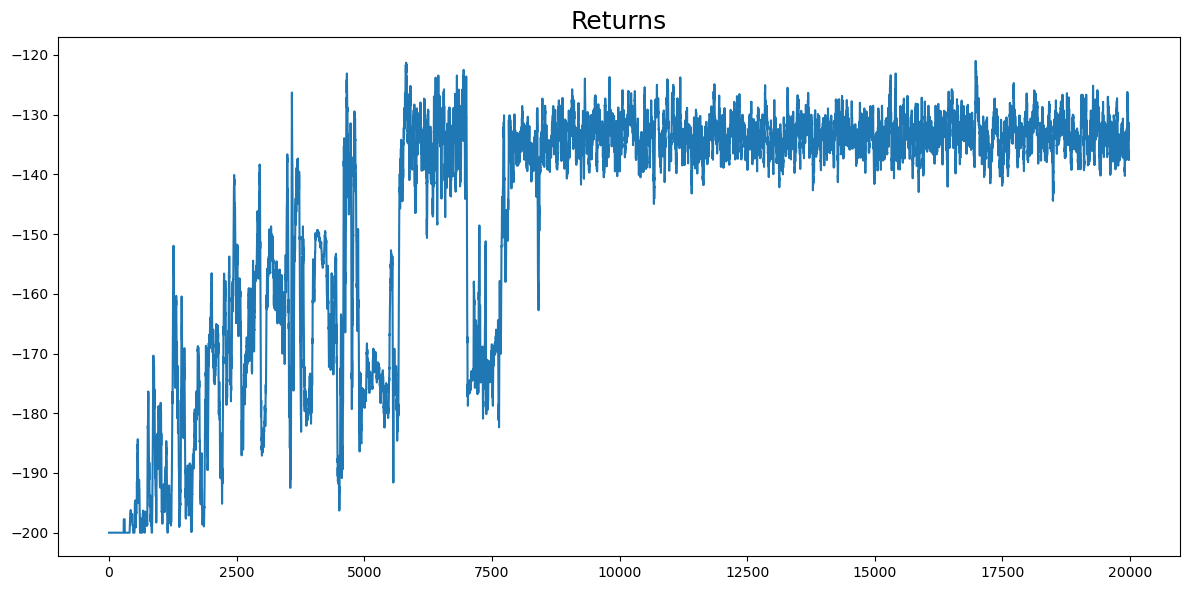

In [13]:
plot_stats(stats)

D:\A\envs\tensorflow\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


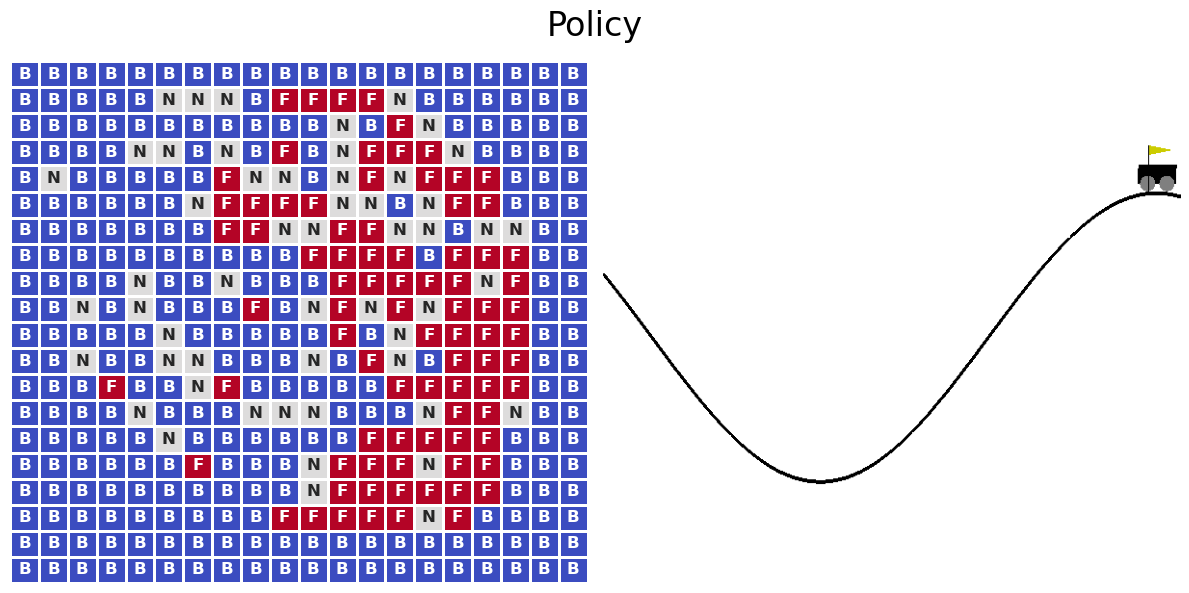

In [14]:
plot_policy(action_values, env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

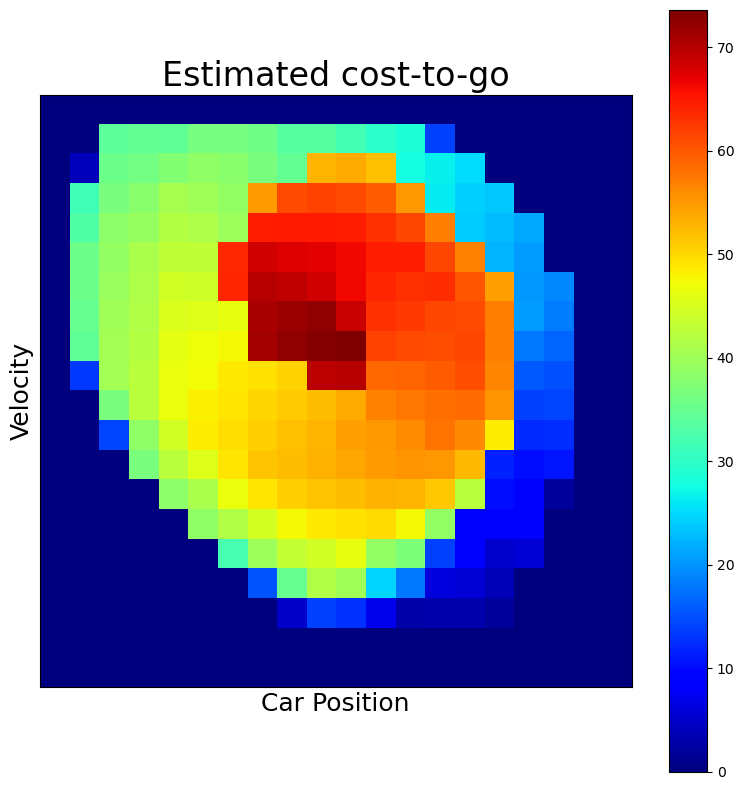

In [15]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

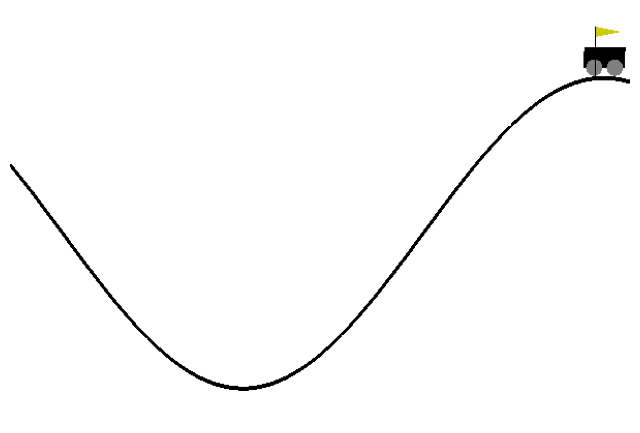

In [16]:
test_agent(saenv, policy, 10)